In [1]:
from utils_gen import extract_from_mnist, visualize_data
from train_gen import prep_data,create_model,training_loop,eval_test,eval_train, plot_losses,visualize_weights_and_signs
from adv_attack_gen import adv_attack,create_adv_test
from RBF_architecture import ShallowRBF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder


In [2]:
#DEFINE CUSTOM MAXOUT MODELS
from needed_archi import MaxoutLayer, DeepMaxoutNetwork, ShallowSoftmaxNetBN

# 1\ DEEP MAXOUT NETWORK

### Data Extraction

In [4]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784')

# Convert labels to integers
mnist.target = mnist.target.astype(int)

data = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
data['target'] = mnist.target

data = data.sample(n=20000, random_state=42)

# Reset the index of the filtered dataset
data = data.reset_index(drop=True)

# Print the shape of the filtered dataset
print("Filtered dataset shape:", data.shape)
print("Labels:", data['target'])


d:\matlab\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
C:\Users\Anna-Louise\AppData\Local\Temp\ipykernel_1840\1308228047.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['target'] = mnist.target


Filtered dataset shape: (20000, 785)
Labels: 0        8
1        4
2        8
3        7
4        7
        ..
19995    8
19996    3
19997    1
19998    7
19999    6
Name: target, Length: 20000, dtype: int32


### Quick visualization

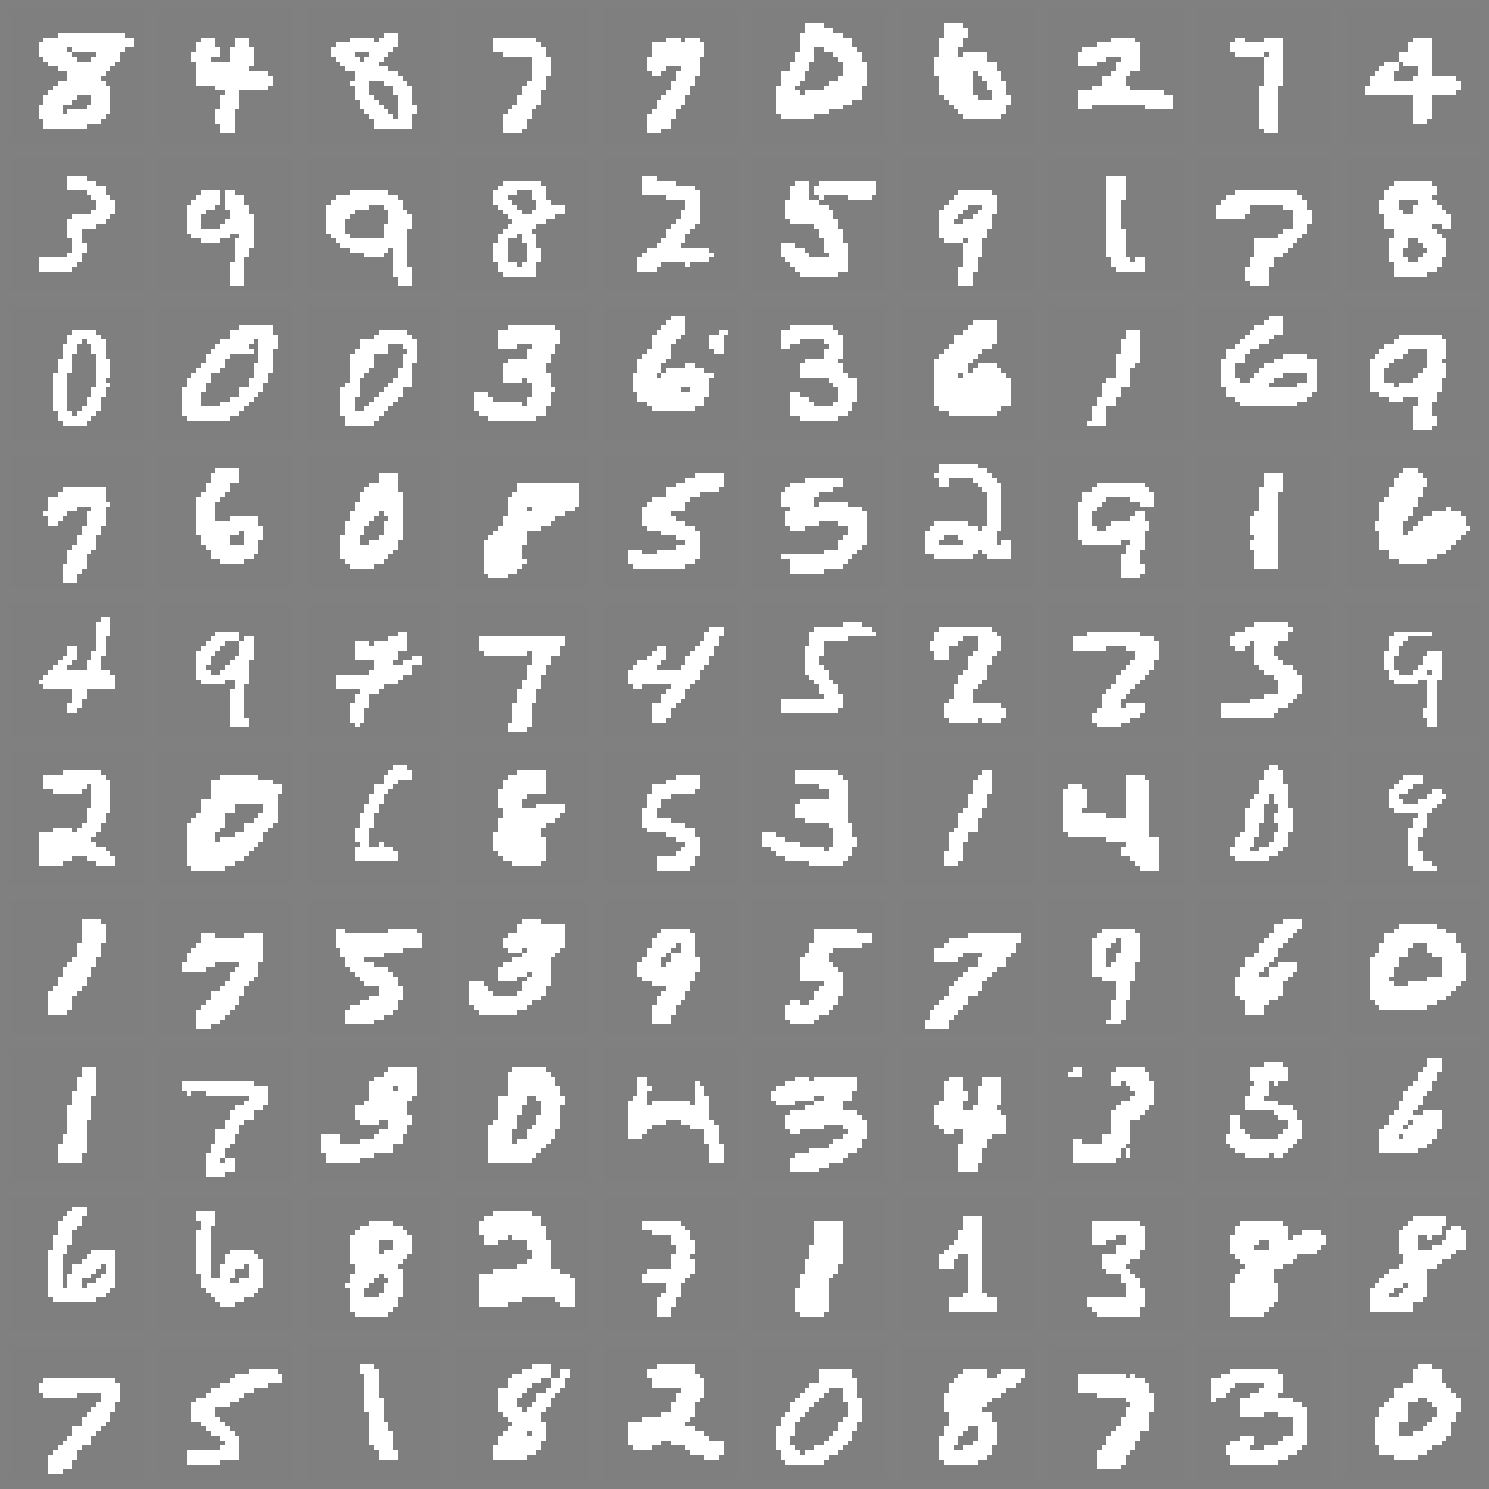

In [5]:
num_rows = 10
num_cols = 10
visualize_data(num_rows,num_cols, data) # to visualize the data

### Data preparation and model creation

In [6]:

# Assuming y is your target labels
y = data['target'].values

# Normalize the data
data_normalized = data.iloc[:, :-1].values / 255.0

# Convert data to PyTorch tensors
X_tensor = torch.tensor(data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
num_classes = len(set(y))
print("Unique classes in target labels:", num_classes)

Unique classes in target labels: 10


In [7]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, 64, shuffle=True)

In [8]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.01
momentum = 0.9
Batch_size =  100
num_classes = 10
input_size = 784
n_channels = 3
num_units = 2
 # Create an instance of the DeepMaxoutNetwork
deep_maxout_model = DeepMaxoutNetwork(input_dim=784, hidden_dim=100, output_dim=10, num_units=2, num_layers=3)

In [9]:
input_size = X_train_tensor.shape[1]
criterion = nn.CrossEntropyLoss()
sgd =  optim.SGD(deep_maxout_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
adam = optim.Adam(deep_maxout_model.parameters(), lr=0.01,weight_decay=1e-2) 
optimizer = adam
 

### Training Loop and performance 

In [10]:
training_loss ,model_trained = training_loop(optimizer, deep_maxout_model , criterion, X_train_tensor, y_train_tensor,num_epochs=num_epochs,batch_size=Batch_size)
# to train the model

Epoch [1/100], Loss: 0.8721
Epoch [2/100], Loss: 0.8087
Epoch [3/100], Loss: 0.7948
Epoch [4/100], Loss: 0.5433
Epoch [5/100], Loss: 0.3421
Epoch [6/100], Loss: 0.2542
Epoch [7/100], Loss: 0.3201
Epoch [8/100], Loss: 0.1959
Epoch [9/100], Loss: 0.3338
Epoch [10/100], Loss: 0.3341
Epoch [11/100], Loss: 0.3547
Epoch [12/100], Loss: 0.2836
Epoch [13/100], Loss: 0.2771
Epoch [14/100], Loss: 0.3436
Epoch [15/100], Loss: 0.3071
Epoch [16/100], Loss: 0.2292
Epoch [17/100], Loss: 0.2261
Epoch [18/100], Loss: 0.3478
Epoch [19/100], Loss: 0.2921
Epoch [20/100], Loss: 0.4642
Epoch [21/100], Loss: 0.2058
Epoch [22/100], Loss: 0.2020
Epoch [23/100], Loss: 0.3450
Epoch [24/100], Loss: 0.2812
Epoch [25/100], Loss: 0.2647
Epoch [26/100], Loss: 0.3500
Epoch [27/100], Loss: 0.3224
Epoch [28/100], Loss: 0.4244
Epoch [29/100], Loss: 0.2960
Epoch [30/100], Loss: 0.3015
Epoch [31/100], Loss: 0.2745
Epoch [32/100], Loss: 0.4530
Epoch [33/100], Loss: 0.2422
Epoch [34/100], Loss: 0.2602
Epoch [35/100], Loss: 0

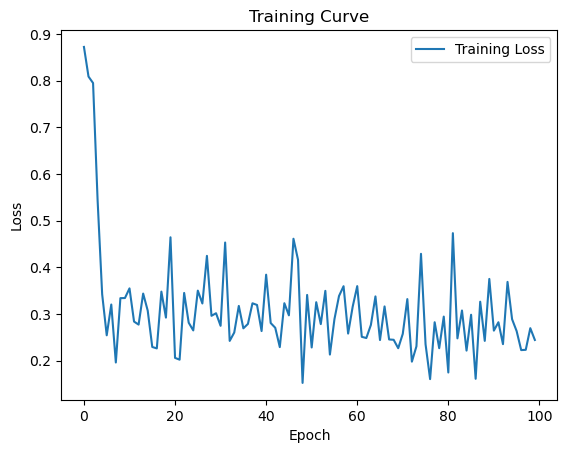

In [11]:
plot_losses(training_loss) # to plot the training loss

In [12]:
eval_train(X_train_tensor,y_train_tensor,model_trained) # to evaluate the model on the training set

Training Accuracy: 92.69%


# 2\ DEEP MAXOUT Vs Adversarial

### Test set for original images

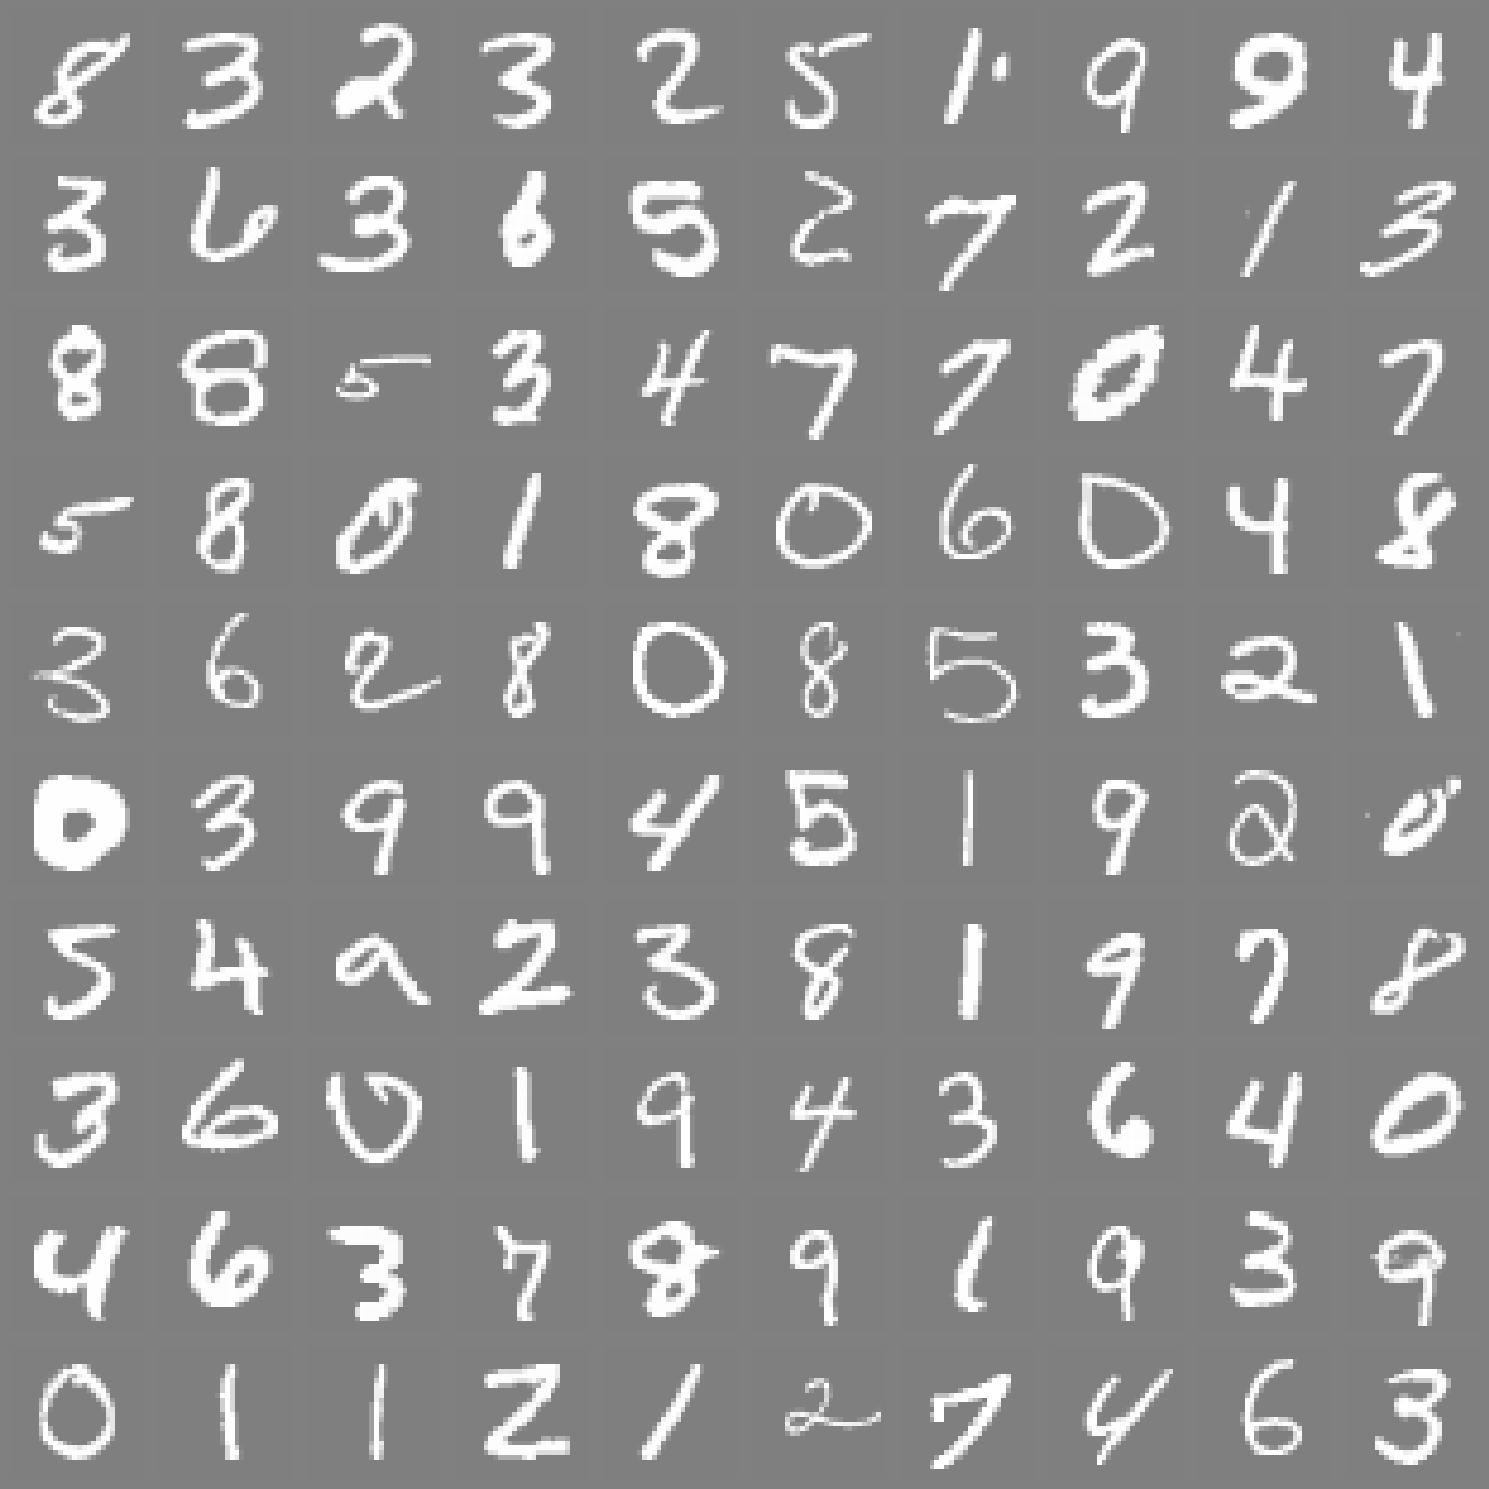

In [13]:

X_test_tensor2 = X_test_tensor.detach().numpy()
visualize_data(num_rows,num_cols,X_test_tensor2) # to visualize the test data

### Evaluation of the model on the unaltered test set

In [14]:
wrong_preds_maxout, correct_preds_maxout,all_preds_maxout  =eval_test(X_test_tensor,y_test_tensor,deep_maxout_model) # to evaluate the model on the test set

Accuracy: 92.67%
Mean Confidence for All Examples: 0.8741
Mean Confidence for Incorrect Predictions: 0.5838


### Creation of the adversarial test set

In [15]:
eps = 0.25
X_test_tensor_adv = create_adv_test(model_trained,X_test_tensor,y_test_tensor,eps,criterion) # to create the adversarial test set

c:\Users\Anna-Louise\Untitled Folder 4\Untitled Folder 1\adv_attack.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alt_im_norm =torch.tensor(alt_im, dtype=torch.float32)


### Visualization of the altered test set 

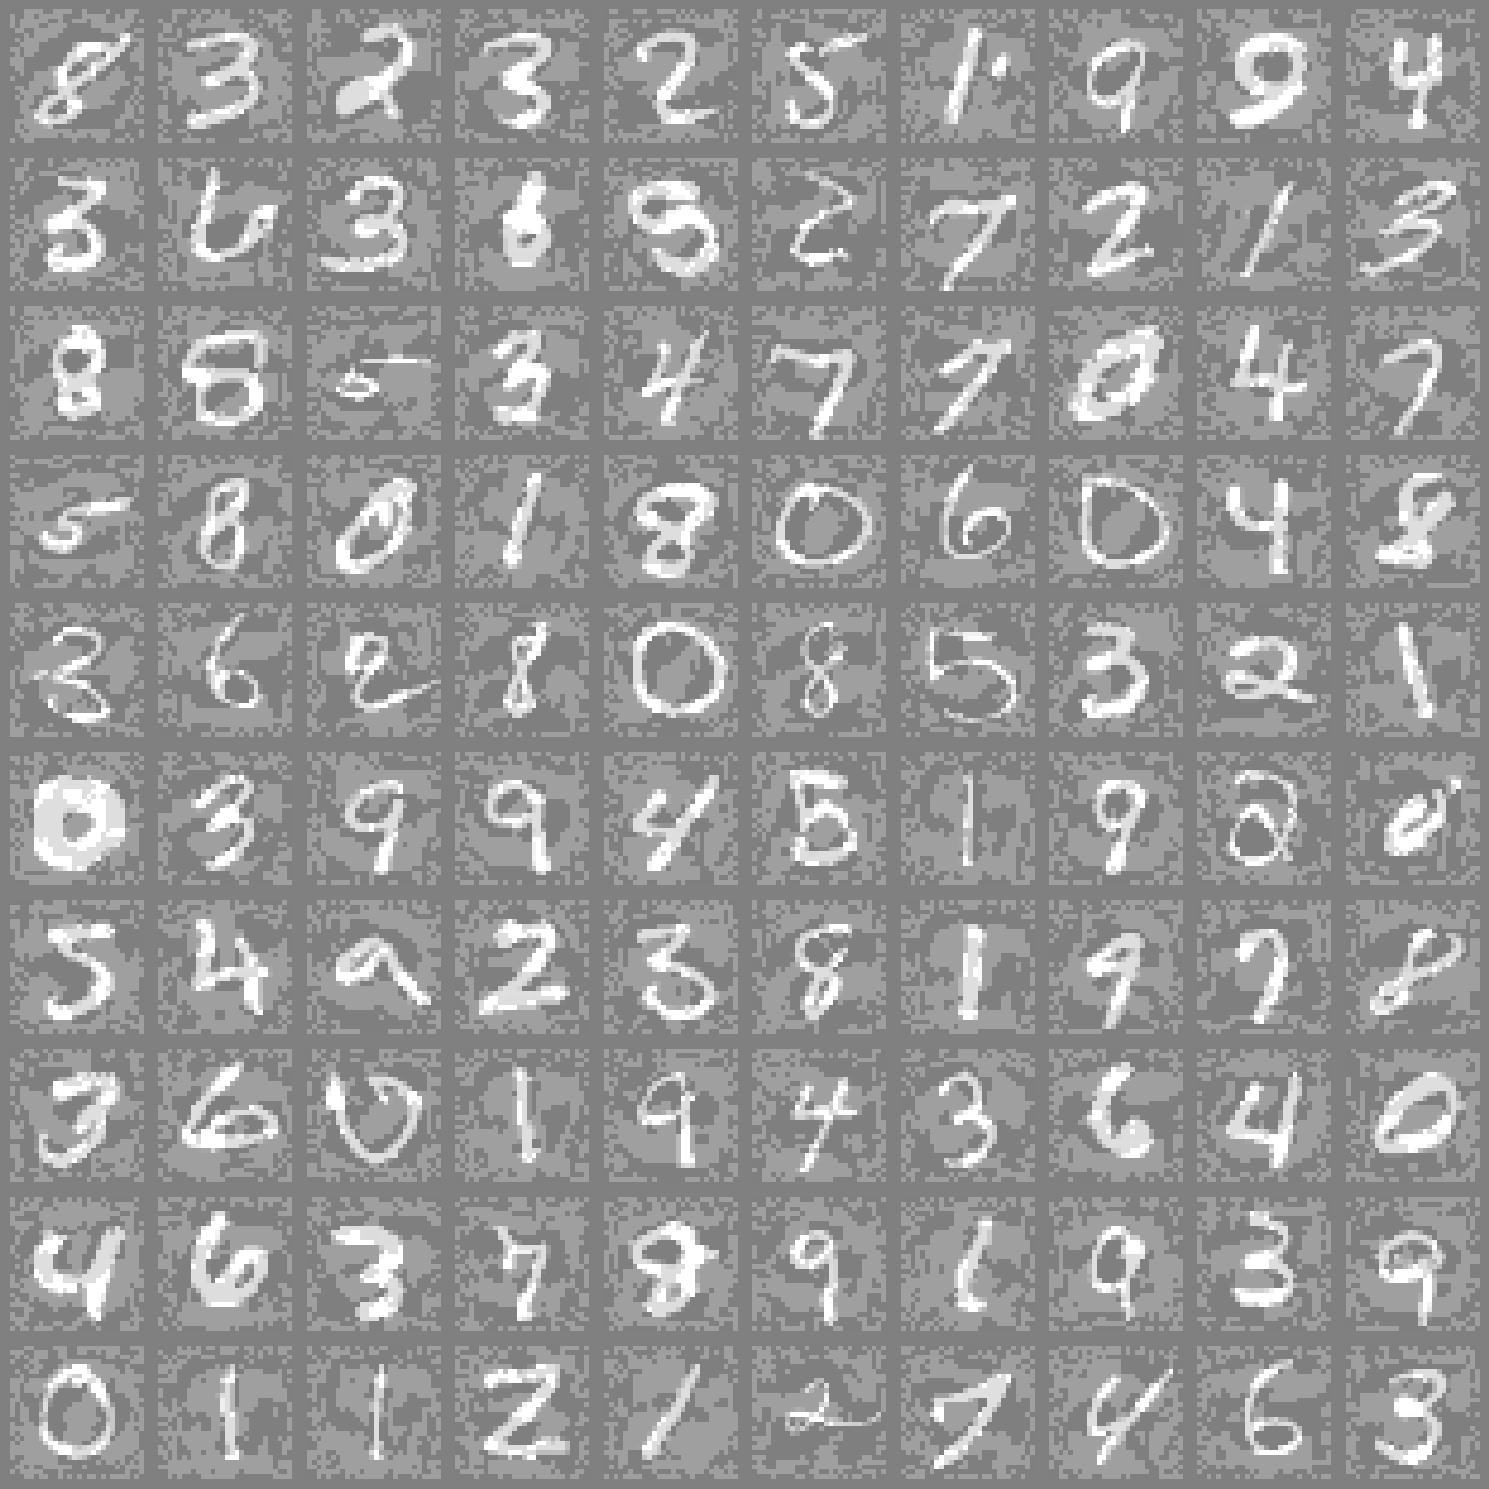

In [16]:
X_test_tensor_adv2 = X_test_tensor_adv.detach().numpy()
visualize_data(num_rows,num_cols,X_test_tensor_adv2) # to visualize the adversarial test set

### Evaluation of the model on the altered test set 

In [17]:
wrong_preds_maxout_adv, correct_preds_maxout_adv,all_preds_maxout_adv   = eval_test(X_test_tensor_adv,y_test_tensor,deep_maxout_model) # to evaluate the model on the adversarial test set

Accuracy: 1.35%
Mean Confidence for All Examples: 0.7439
Mean Confidence for Incorrect Predictions: 0.7464


# SHALLOW RBF

In [18]:

batch_images,batch_labels= next(iter(train_loader))

centers = batch_images

In [19]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.01
momentum = 0.9
Batch_size =  100
num_classes = 10
input_size = 784
n_channels = 3
num_units = 2
 # Create an instance of the DeepMaxoutNetwork
RBF_model = ShallowRBF(input_dim=784, num_classes=10, num_centers=centers.shape[0])

In [20]:
input_size = X_train_tensor.shape[1]
criterion = nn.CrossEntropyLoss()
sgd =  optim.SGD(RBF_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
adam = optim.Adam(RBF_model.parameters(), lr=0.01) 
optimizer = adam

### Training Loop and performance 

In [21]:
training_loss_RBF ,model_trained_RBF = training_loop(optimizer, RBF_model , criterion, X_train_tensor, y_train_tensor,num_epochs=num_epochs,batch_size=Batch_size)
# to train the model

Epoch [1/100], Loss: 1.4788
Epoch [2/100], Loss: 1.1286
Epoch [3/100], Loss: 0.8586
Epoch [4/100], Loss: 0.9633
Epoch [5/100], Loss: 0.8044
Epoch [6/100], Loss: 0.8553
Epoch [7/100], Loss: 0.8227
Epoch [8/100], Loss: 0.7842
Epoch [9/100], Loss: 0.9988
Epoch [10/100], Loss: 0.7201
Epoch [11/100], Loss: 0.7381
Epoch [12/100], Loss: 0.8459
Epoch [13/100], Loss: 0.7397
Epoch [14/100], Loss: 0.8169
Epoch [15/100], Loss: 0.4810
Epoch [16/100], Loss: 0.8797
Epoch [17/100], Loss: 0.6887
Epoch [18/100], Loss: 0.6694
Epoch [19/100], Loss: 0.5083
Epoch [20/100], Loss: 0.4798
Epoch [21/100], Loss: 0.7584
Epoch [22/100], Loss: 0.6589
Epoch [23/100], Loss: 0.7841
Epoch [24/100], Loss: 0.6476
Epoch [25/100], Loss: 0.5604
Epoch [26/100], Loss: 0.5446
Epoch [27/100], Loss: 0.7234
Epoch [28/100], Loss: 0.6392
Epoch [29/100], Loss: 0.5998
Epoch [30/100], Loss: 0.6992
Epoch [31/100], Loss: 0.8412
Epoch [32/100], Loss: 0.5998
Epoch [33/100], Loss: 0.6659
Epoch [34/100], Loss: 0.5210
Epoch [35/100], Loss: 0

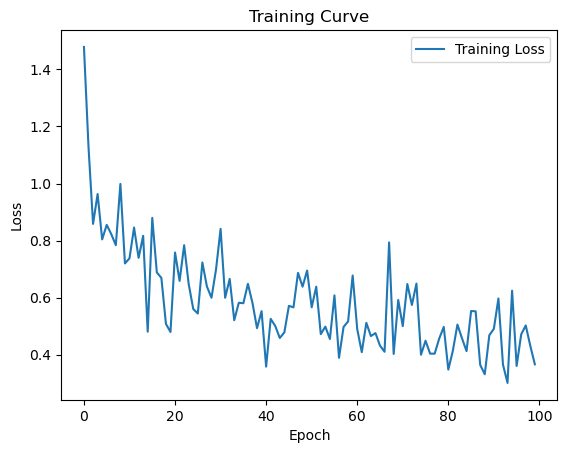

In [22]:
plot_losses(training_loss_RBF) # to plot the training loss

In [23]:
eval_train(X_train_tensor,y_train_tensor,model_trained_RBF) # to evaluate the model on the training set

Training Accuracy: 85.31%


### Evaluation of the model on the unaltered test set

In [24]:
wrong_preds_RBF, correct_preds_RBF,all_preds_RBF  =eval_test(X_test_tensor,y_test_tensor,RBF_model) # to evaluate the model on the test set

Accuracy: 84.82%
Mean Confidence for All Examples: 0.8258
Mean Confidence for Incorrect Predictions: 0.6279


### Evaluation of the model on the altered test set generated by the deep maxout

In [25]:
wrong_preds_RBF_adv, correct_preds_RBF_adv,all_preds_RBF_adv   =eval_test(X_test_tensor_adv,y_test_tensor,RBF_model) # to evaluate the RBF model on the adversarial test set generated by the maxout model

Accuracy: 2.02%
Mean Confidence for All Examples: 0.7896
Mean Confidence for Incorrect Predictions: 0.7926


In [26]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.01
momentum = 0.9
Batch_size = 100
num_classes = 10
input_size = 784
n_channels = 3
num_units = 2
 # Create an instance of the DeepMaxoutNetwork
ShallowSoftmax_model = ShallowSoftmaxNetBN(input_dim=784, output_dim=10)


In [27]:
input_size = X_train_tensor.shape[1]
criterion = nn.CrossEntropyLoss()
sgd =  optim.SGD(ShallowSoftmax_model.parameters(), lr=0.01,weight_decay=1e-2)
adam = optim.Adam(ShallowSoftmax_model.parameters(), lr=0.01,weight_decay=1e-4)
optimizer = adam

### Training Loop and performance 

In [28]:
training_loss_shallowsoft ,model_trained_shallowsoft = training_loop(optimizer, ShallowSoftmax_model , criterion, X_train_tensor, y_train_tensor,num_epochs=num_epochs,batch_size=Batch_size)
# to train the model

Epoch [1/100], Loss: 1.7161
Epoch [2/100], Loss: 1.6520
Epoch [3/100], Loss: 1.6031
Epoch [4/100], Loss: 1.5948
Epoch [5/100], Loss: 1.6391
Epoch [6/100], Loss: 1.5912
Epoch [7/100], Loss: 1.5692
Epoch [8/100], Loss: 1.5554
Epoch [9/100], Loss: 1.5603
Epoch [10/100], Loss: 1.5922
Epoch [11/100], Loss: 1.6144
Epoch [12/100], Loss: 1.5584
Epoch [13/100], Loss: 1.5198
Epoch [14/100], Loss: 1.5400
Epoch [15/100], Loss: 1.5433
Epoch [16/100], Loss: 1.5963
Epoch [17/100], Loss: 1.6042
Epoch [18/100], Loss: 1.5331
Epoch [19/100], Loss: 1.5861
Epoch [20/100], Loss: 1.5872
Epoch [21/100], Loss: 1.5039
Epoch [22/100], Loss: 1.5989
Epoch [23/100], Loss: 1.5983
Epoch [24/100], Loss: 1.5614
Epoch [25/100], Loss: 1.5515
Epoch [26/100], Loss: 1.5887
Epoch [27/100], Loss: 1.5224
Epoch [28/100], Loss: 1.5571
Epoch [29/100], Loss: 1.5513
Epoch [30/100], Loss: 1.5441
Epoch [31/100], Loss: 1.5912
Epoch [32/100], Loss: 1.5651
Epoch [33/100], Loss: 1.5808
Epoch [34/100], Loss: 1.6118
Epoch [35/100], Loss: 1

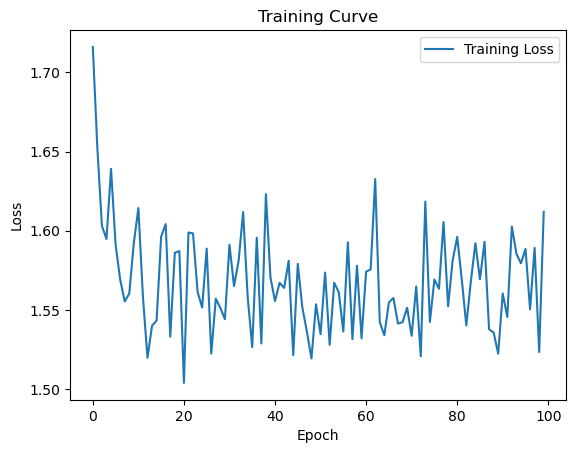

In [29]:
plot_losses(training_loss_shallowsoft) # to plot the training loss

In [30]:
eval_train(X_train_tensor,y_train_tensor,model_trained_shallowsoft) # to evaluate the model on the training set

Training Accuracy: 93.29%


### Evaluation of the model on the unaltered test set

In [31]:
wrong_preds_shallowsoft, correct_preds_shallowsoft,all_preds_shallowsoft  = eval_test(X_test_tensor,y_test_tensor,model_trained_shallowsoft) # to evaluate the model on the test set

Accuracy: 91.20%
Mean Confidence for All Examples: 0.2230
Mean Confidence for Incorrect Predictions: 0.1904


### Evaluation of the model on the altered test set generated by the deep maxout

In [32]:
wrong_preds_shallowsoft_adv, correct_preds_shallowsoft_adv, all_preds_shallowsoft_adv  =eval_test(X_test_tensor_adv,y_test_tensor,model_trained_shallowsoft) # to evaluate the RBF model on the adversarial test set generated by the maxout model

Accuracy: 1.27%
Mean Confidence for All Examples: 0.2097
Mean Confidence for Incorrect Predictions: 0.2100


## Calculation of the similar prediction's percentages between the different neural networks implemented

In [33]:
# Count the total number of adversarial examples where both Maxout networks and the RBF network made wrong predictions
same_wrong_preds = sum(wrong_preds_maxout_adv[i] == wrong_preds_RBF_adv[i] for i in range(min(len(wrong_preds_maxout_adv), len(wrong_preds_RBF_adv))))

# Count the total number of adversarial examples
total_examples = min(len(wrong_preds_maxout_adv), len(wrong_preds_RBF_adv))

# Calculate the percentage
percentage_same_wrong_preds = (same_wrong_preds / total_examples) * 100

print("On missclassified examples : Percentage of how many times the shallow RBF predicts the maxouts class :")
print(percentage_same_wrong_preds)

On missclassified examples : Percentage of how many times the shallow RBF predicts the maxouts class :
20.770604746108702


In [34]:
# Count the total number of adversarial examples where both Maxout networks and the RBF network made wrong predictions
same_wrong_preds2 = sum(wrong_preds_maxout_adv[i] == wrong_preds_shallowsoft_adv[i] for i in range(min(len(wrong_preds_maxout_adv), len(wrong_preds_shallowsoft_adv))))

# Count the total number of adversarial examples
total_examples2 = min(len(wrong_preds_maxout_adv), len(wrong_preds_shallowsoft_adv))

# Calculate the percentage
percentage_same_wrong_preds2 = (same_wrong_preds2 / total_examples2) * 100

print("On missclassified examples : Percentage of how many times the shallow softmax predicts the maxouts class :")
print(percentage_same_wrong_preds2)

On missclassified examples : Percentage of how many times the shallow softmax predicts the maxouts class :
32.28585909782058


In [35]:
# Count the total number of adversarial examples where both Maxout networks and the RBF network made wrong predictions
same_all_preds_msf = sum(all_preds_maxout_adv[i] == all_preds_shallowsoft_adv[i] for i in range(min(len(all_preds_maxout_adv), len(wrong_preds_shallowsoft_adv))))

# Count the total number of adversarial examples
total_ex_all_msf = min(len(all_preds_maxout_adv), len(all_preds_shallowsoft_adv))

# Calculate the percentage
percentage_same_all_preds_msf = (same_all_preds_msf / total_ex_all_msf) * 100

print("Percentage of how many times the shallow softmax predicts the maxouts class :")
print(percentage_same_all_preds_msf)

Percentage of how many times the shallow softmax predicts the maxouts class :
68.125


In [36]:
# Count the total number of adversarial examples where both Maxout networks and the RBF network made wrong predictions
same_all_preds_mrbf = sum(all_preds_maxout_adv[i] == all_preds_RBF_adv[i] for i in range(min(len(wrong_preds_maxout_adv), len(wrong_preds_RBF_adv))))

# Count the total number of adversarial examples
total_ex_all_mrbf = min(len(all_preds_maxout_adv), len(all_preds_RBF_adv))

# Calculate the percentage
percentage_same_all_preds_mrbf = (same_all_preds_mrbf / total_ex_all_mrbf) * 100

print("Percentage of how many times the RBF predicts the maxouts class :")
print(percentage_same_all_preds_mrbf)

Percentage of how many times the RBF predicts the maxouts class :
50.275000000000006


In [37]:
# Count the total number of adversarial examples where both Maxout networks and the RBF network made wrong predictions
same_all_preds_SFrbf = sum(all_preds_RBF_adv[i] == all_preds_shallowsoft_adv[i] for i in range(min(len(wrong_preds_RBF_adv), len(all_preds_shallowsoft_adv))))

# Count the total number of adversarial examples
total_ex_all_SFrbf = min(len(all_preds_RBF_adv), len(all_preds_shallowsoft_adv))

# Calculate the percentage
percentage_same_all_preds_SFrbf = (same_all_preds_SFrbf / total_ex_all_SFrbf) * 100

print("Percentage of how many times the RBF predicts the softmaxs class :")
print(percentage_same_all_preds_SFrbf)

Percentage of how many times the RBF predicts the softmaxs class :
49.225
